<a href="https://colab.research.google.com/github/Luan-DataSpot/case-da-ifood-2025-luan-pallin/blob/main/Case_iFood_Versao_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# - ❗ Instruções de Uso

##Resumo de execução

## ⚠️ UTILIZAR Google Colab COMO AMBIENTE DE REPRODUÇÃO | NOTEBOOK


### 1. Preparação do Ambiente
- Execute todas as células na ordem apresentada
 - Apenas conecte o cluester e clique em `Executar Tudo`
- Aguarde o carregamento completo dos dados antes de prosseguir
  - O tempo de execução completo leva em torno de **30 minutos**
- Monitore o uso de memória do Colab observando a caixinha RAM, caso necessário execute a célula **"Apenas em caso Sobrecarga de memória RAM"**

### 2. Execução
- O notebook é auto-suficiente e não requer configurações adicionais, tudo já está previamente setado nas primeiras células
- Todos os dados são carregados diretamente dos buckets S3, segundo a sua extensão
- As visualizações são exibidas automaticamente

### 3. Resultados
- Gráficos estáticos em PNG
- Relatório executivo no output do notebook, tema por tema
- Link do PDF com conclusão completa, no final do notebook. (Já enviado no anexo do e-mail com link do repositório deste notebook)


### 4. Troubleshooting
- Caso o erro a seguir ocorra, apenas rode novamente o notebook, as depêndencias serão instaladas normalmente:
> `WARNING: The following packages were previously imported in this runtime:`
>   `[site]`
>`You must restart the runtime in order to use newly installed versions.`

- Em caso de erro de memória: reinicie o runtime, execute novamente ou acesse no Índice: **"Apenas em caso Sobrecarga de memória RAM"**
- Se algum dataset não carregar: verifique a conectividade com a internet

---
**📧 Owner:** Luan Pallin  | *Anl PL BI*

**📅 Data:** 2025  |


# 1️⃣ Dependências e configurações iniciais


## 1.1 Instalando Spark, Plotly, Kaleido e Java




In [1]:
# Instalar dependências (executar apenas uma vez no início)
!pip install pyspark findspark plotly kaleido
!apt-get install openjdk-11-jdk-headless -qq > /dev/null #Necessário para rodar o Hadoop e consumir os buckets na AWS

## 1.2 Importando bibliotecas e configurando OS



In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/.local/lib/python3.10/site-packages/pyspark" #Rodar apenas se vc não tiver Python no seu ambiente

import findspark
# Apenas em caso de erro Spark Home
# findspark.init(spark_home='/usr/local/lib/python3.11/dist-packages/pyspark')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pyspark.sql.functions as F

# Estatística
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

## 1.3 Apenas em caso Sobrecarga de memória RAM
- Opcional

In [3]:
## USAR APENAS CASO O AMBIEMTE APRESENTE ERRO DE MEMÓRIA
## Apenas descomente, apagando os "#" e execute está célula


#def cleanup_resources():
#     """
#     Limpa recursos do Spark para otimizar memória
#     """
#     print("🧹 Limpando recursos...")

#     # Uncache dataframes
#     df_main.unpersist()

#     # Parar Spark
#     spark.stop()

#     print("✅ Recursos limpos com sucesso!")

# # Limpar ao final
# cleanup_resources()

## 1.4 Cria Sessão SPARK

In [4]:
def create_spark_session(app_name="iFood_Case_Analysis"):
    try:
        spark = SparkSession.builder \
            .appName(app_name) \
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.fs.s3a.endpoint", "s3-sa-east-1.amazonaws.com") \
            .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider") \
            .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.1") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
            .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
            .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
            .config("spark.sql.adaptive.skewJoin.enabled", "true") \
            .config("spark.dynamicAllocation.enabled", "false") \
            .config("spark.executor.memory", "8g") \
            .config("spark.driver.memory", "6g") \
            .config("spark.executor.cores", "4") \
            .config("spark.sql.shuffle.partitions", "300") \
            .getOrCreate()

        print("✅ Sessão Spark criada com sucesso!")
        print(f"Spark Version: {spark.version}")

        return spark

    except Exception as e:
        print(f"❌ Erro ao criar sessão Spark: {e}")
        return None

# Criar sessão Spark
spark = create_spark_session()

✅ Sessão Spark criada com sucesso!
Spark Version: 3.5.1


# 2️⃣ Consome - Buckets no S3
- Carrega todos os datasets

## 2.1 Consumindo buckets com arquivos de Extensão Json e CSV

In [5]:
## Buckets são públicos, não é necessário passar nenhuma autenticação.
## Consegui ver utilizar curl, passando a URL orinal contida no arquivo do case
## Obtive protocolo 200 que significa conexão bem sucedida -- Processo realizado localmente pelo terminal.

# Caminho padrão da AWS segundo a URL fornecida
FILE_PATHS = {
    'orders': 's3a://data-architect-test-source/order.json.gz',      # 3.6M registros
    'consumers': 's3a://data-architect-test-source/consumer.csv.gz',     # 806k usuários
    'restaurants': 's3a://data-architect-test-source/restaurant.csv.gz', # 7k restaurantes
}

# Tempo de execução: Em torno de 15 minutos
def load_datasets(paths, spark):

    print("🔄 Carregando datasets...\n")
    print("Pode levar cerca de 15 minutos")
    """
    Função para carregar automaticamente todos os arquivos de diferentes formatos em DataFrames.

    Argumentos:
        paths (dict): Dicionário com nomes e caminhos para os arquivos, exceto com extensão Tars, que precisa de um tratamento especial
        spark (SparkSession): Sessão Spark.

    Returns:
        dict: Dicionário com DataFrames PySpark.
    """
    dfs = {}

    for name, path in paths.items():
        print(f"📥 Processando arquivo: {name}...")

        # Verifica formato do arquivo
        if '.json' in path:
            df = spark.read.json(path)

        elif '.csv' in path:
            df = spark.read.option("header", "true").csv(path)

        else:
            print(f"⚠️ Formato de arquivo não suportado: {path}")
            continue

        # Armazena o DataFrame em cache para otimizar performance
        dfs[name] = df.cache()
        print(f"✅ {name}: {df.count()} registros carregados.")

    return dfs


dfs = load_datasets(FILE_PATHS, spark)

🔄 Carregando datasets...

Pode levar cerca de 15 minutos
📥 Processando arquivo: orders...
✅ orders: 3670826 registros carregados.
📥 Processando arquivo: consumers...
✅ consumers: 806156 registros carregados.
📥 Processando arquivo: restaurants...
✅ restaurants: 7292 registros carregados.


## 2.1.1 Consumindo bucket com arquivo de extensão .tar

In [6]:
s3_url_ab_test = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz" #Aqui ab_test com extensão tars e compactado

import tarfile
import urllib.request

local_tar_gz = "ab_test_ref.tar.gz"
urllib.request.urlretrieve(s3_url_ab_test, local_tar_gz) #Baixa o arquivo .tar.gz localmente
print(f"👉 Arquivo baixado: {local_tar_gz}")

extract_path = "./extracted_data/"
os.makedirs(extract_path, exist_ok=True)  # Cria o diretório, se necessário

with tarfile.open(local_tar_gz, "r:gz") as tar: # Extrai o arquivo .tar.gz
    tar.extractall(path=extract_path)
    print(f"👉 Arquivos extraídos para: {extract_path}")

extracted_files = [
    file for file in os.listdir(extract_path) # Lista os arquivos extraídos
    if not file.startswith("._")  # Ignora o arquivo oculto a pasta
]
print(f"📂 Arquivos extraídos: {extracted_files}")

df_ab_test = None
for file in extracted_files:
    file_path = os.path.join(extract_path, file)  # Caminho relativo
    ab_test_path = os.path.abspath(file_path)  # Transformar em caminho absoluto

    print(f"📗 Carregando arquivo CSV: {ab_test_path}")
    df_ab_test = spark.read.option("header", "true").csv(ab_test_path) # O PDF do case ja sinalizou que era um CSV

    # Interromper ao carregar o primeiro arquivo válido
    if df_ab_test:
        break

👉 Arquivo baixado: ab_test_ref.tar.gz
👉 Arquivos extraídos para: ./extracted_data/
📂 Arquivos extraídos: ['ab_test_ref.csv']
📗 Carregando arquivo CSV: /content/extracted_data/ab_test_ref.csv


## 2.2 Cria Dfs

In [7]:
df_ab_test = df_ab_test
df_orders = dfs['orders']
df_consumers = dfs['consumers']
df_restaurants = dfs['restaurants']

## Verificando conteúdo dos Dfs, apenas um double Check

In [8]:
print(f"✅ Datasets carregados:")
print(f"📦 Pedidos: {df_orders.count():,} registros")
print(f"👥 Consumidores: {df_consumers.count():,} registros")
print(f"🍽️ Restaurantes: {df_restaurants.count():,} registros")
print(f"🧪 Teste A/B: {df_ab_test.count():,} registros")

✅ Datasets carregados:
📦 Pedidos: 3,670,826 registros
👥 Consumidores: 806,156 registros
🍽️ Restaurantes: 7,292 registros
🧪 Teste A/B: 806,467 registros


# 3️⃣ Tratando Datasets

## 3.1 Carregando Schema e Analisando Dados da Orders

In [9]:
def explore_datasets(df_orders, df_consumers, df_restaurants, df_ab_test):
    """
    Realiza análise exploratória dos datasets
    """
    print("🔍 ANÁLISE EXPLORATÓRIA DOS DADOS\n")

    # Schema dos datasets
    print("📋 SCHEMAS DOS DATASETS:")
    print("\n🛒 PEDIDOS:")
    df_orders.printSchema()

    print("\n👥 CONSUMIDORES:")
    df_consumers.printSchema()

    print("\n🍽️ RESTAURANTES:")
    df_restaurants.printSchema()

    print("\n🧪 TESTE A/B:")
    df_ab_test.printSchema()

    print("\n📊 DISTRIBUIÇÃO DOS GRUPOS DO TESTE A/B:")
    ab_distribution = df_ab_test.groupBy("is_target").count().collect()
    for row in ab_distribution:
        print(f"{row['is_target']}: {row['count']:,} usuários")

    print("\n📅 ANÁLISE TEMPORAL DOS PEDIDOS:")
    df_orders_with_date = df_orders.withColumn("order_moment",
                                               to_date(col("order_created_at")))

    temporal_analysis = df_orders_with_date.groupBy("order_moment") \
                                          .agg(count("*").alias("total_orders"),
                                               avg("order_total_amount").alias("avg_amount")) \
                                          .orderBy("order_moment")

    temporal_analysis.show(50)

    return df_orders_with_date

df_orders_processed = explore_datasets(df_orders, df_consumers, df_restaurants, df_ab_test)

🔍 ANÁLISE EXPLORATÓRIA DOS DADOS

📋 SCHEMAS DOS DATASETS:

🛒 PEDIDOS:
root
 |-- cpf: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_country: string (nullable = true)
 |-- delivery_address_district: string (nullable = true)
 |-- delivery_address_external_id: string (nullable = true)
 |-- delivery_address_latitude: string (nullable = true)
 |-- delivery_address_longitude: string (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- delivery_address_zip_code: string (nullable = true)
 |-- items: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_latitude: string (nullable = true)
 |-- merchant_longitude: string (nullable = true)
 |-- merchant_timezone: string (nullable = true)
 |-- order_created_at: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_scheduled: boolean (nul

## 3.2 Limpando Dados e Executando Joins
- Trata os seguintes casos de forma simplificada:
  - Nulos
  - Chaves Primárias dúplicadas
  - Datas Vazias ou Nulas
  - Valores de Pedidos Zerados

- Também cria um Dataset unificado após tratamento chamado df_main, com as principais colunas de cada set a ser utilizado

In [10]:
def clean_and_prepare_data(df_orders, df_consumers, df_restaurants, df_ab_test):
    """
    Limpa e prepara os dados para análise
    """
    print("🧹 LIMPEZA E PREPARAÇÃO DOS DADOS\n")
    print("Tempo de execução: 10 minutos \n")
    # Limpeza de pedidos
    df_orders_clean = df_orders.filter(
        (col("order_total_amount") > 0) &
        (col("order_total_amount").isNotNull()) &
        (col("customer_id").isNotNull()) &
        (col("order_created_at").isNotNull())
    ).withColumn("order_date", to_date(col("order_created_at"))) \
     .withColumn("order_timestamp", to_timestamp(col("order_created_at")))

    quantiles = df_orders_clean.approxQuantile("order_total_amount", [0.01, 0.98], 0.01) # Removendo outliers no limite inferior e superior
    lower, upper = quantiles

    df_orders_clean = df_orders_clean.filter(
        (col("order_total_amount") >= lower) &
        (col("order_total_amount") <= upper)
)

    # Limpeza de consumidores
    df_consumers_clean = df_consumers.filter(
        col("customer_id").isNotNull()
    )

    # Cria dataset principal com join
    df_main = df_orders_clean.join(
        df_ab_test.select("customer_id", "is_target"),
        "customer_id",
        "inner"
    ).join(
        df_consumers_clean.select("customer_id", "created_at"),
        "customer_id",
        "left"
    )

    # Adiciona métricas derivadas
    df_main = df_main.withColumn("month_year",
                                date_format(col("order_date"), "yyyy-MM")) \
                     .withColumn("day_of_week",
                                date_format(col("order_date"), "EEEE")) \
                     .withColumn("week_of_year",
                                weekofyear(col("order_date")))

    # Cache para performance
    df_main.cache()

    print(f"✅ Dataset principal criado: {df_main.count():,} registros")
    print(f"🎯 Período: {df_main.agg(min('order_date')).collect()[0][0]} a {df_main.agg(max('order_date')).collect()[0][0]}")

    return df_main

# Preparar dados
df_main = clean_and_prepare_data(df_orders, df_consumers, df_restaurants, df_ab_test)

🧹 LIMPEZA E PREPARAÇÃO DOS DADOS

Tempo de execução: 10 minutos 

✅ Dataset principal criado: 3,590,704 registros
🎯 Período: 2018-12-03 a 2019-01-31


# 4️⃣ Analisando Dados
- Considera hipóteses relevantes para o Caso

## 4.1 Verifica estatísticas p/ grupo do teste

In [11]:
def ab_test_analysis(df_main):
    """
    Realiza análise completa do teste A/B
    """
    print("🧪 ANÁLISE DO TESTE A/B\n")
    print("Tempo de execução: 2 minutos\n")

    # Métricas por grupo
    metrics_by_group = df_main.groupBy("is_target") \
        .agg(
            count("*").alias("total_orders"),
            countDistinct("customer_id").alias("unique_users"),
            avg("order_total_amount").alias("avg_order_value"),
            sum("order_total_amount").alias("total_revenue"),
            stddev("order_total_amount").alias("std_order_value")
        ).collect()

    print("📊 MÉTRICAS POR GRUPO:")
    for row in metrics_by_group:
        group = "CONTROLE" if row["is_target"] == "control" else "TARGET"
        print(f"\n{group}:")
        print(f"  📦 Total de pedidos: {row['total_orders']:,}")
        print(f"  👥 Usuários únicos: {row['unique_users']:,}")
        print(f"  💰 Ticket médio: R$ {row['avg_order_value']:.2f}")
        print(f"  💵 Receita total: R$ {row['total_revenue']:,.2f}")
        print(f"  📈 Desvio padrão: R$ {row['std_order_value']:.2f}")

    # Calcular frequência de pedidos por usuário
    user_frequency = df_main.groupBy("customer_id", "is_target") \
                           .count() \
                           .withColumnRenamed("count", "order_frequency")

    frequency_stats = user_frequency.groupBy("is_target") \
        .agg(
            avg("order_frequency").alias("avg_frequency"),
            stddev("order_frequency").alias("std_frequency")
        ).collect()

    print("\n📈 FREQUÊNCIA DE PEDIDOS POR USUÁRIO:")
    for row in frequency_stats:
        group = "CONTROLE" if row["is_target"] == "control" else "TARGET"
        print(f"{group}: {row['avg_frequency']:.2f} ± {row['std_frequency']:.2f} pedidos/usuário")

    return metrics_by_group, user_frequency

# Executar análise A/B
ab_metrics, user_freq = ab_test_analysis(df_main)

🧪 ANÁLISE DO TESTE A/B

Tempo de execução: 2 minutos

📊 MÉTRICAS POR GRUPO:

CONTROLE:
  📦 Total de pedidos: 1,495,952
  👥 Usuários únicos: 356,482
  💰 Ticket médio: R$ 44.64
  💵 Receita total: R$ 66,774,945.10
  📈 Desvio padrão: R$ 25.01

TARGET:
  📦 Total de pedidos: 2,094,752
  👥 Usuários únicos: 441,643
  💰 Ticket médio: R$ 44.63
  💵 Receita total: R$ 93,485,225.80
  📈 Desvio padrão: R$ 25.06

📈 FREQUÊNCIA DE PEDIDOS POR USUÁRIO:
CONTROLE: 4.20 ± 5.40 pedidos/usuário
TARGET: 4.74 ± 5.79 pedidos/usuário


## 4.2 Cria visualização de série temporal

In [12]:
def create_temporal_analysis(df_main):
    """
    Cria análise temporal com visualizações interativas
    """
    print("📈 CRIANDO ANÁLISE TEMPORAL...\n")
    print("Tempo de execução: 2 minutos")


    # Métricas diárias por grupo
    daily_metrics = df_main.groupBy("order_date", "is_target") \
        .agg(
            count("*").alias("daily_orders"),
            countDistinct("customer_id").alias("daily_users"),
            avg("order_total_amount").alias("daily_avg_ticket"),
            sum("order_total_amount").alias("daily_revenue")
        ).orderBy("order_date")

    # Converter para Pandas para visualização
    daily_metrics_pd = daily_metrics.toPandas()

    #Separa grupos
    control_data = daily_metrics_pd[daily_metrics_pd['is_target'] == 'control']
    treatment_data = daily_metrics_pd[daily_metrics_pd['is_target'] == 'target']

    # Cria gráficos de série temporal
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Pedidos Diários', 'Usuários Únicos Diários',
                       'Ticket Médio Diário', 'Receita Diária'),
        vertical_spacing=0.12
    )

    metrics = [
        ('daily_orders', 'Pedidos'),
        ('daily_users', 'Usuários'),
        ('daily_avg_ticket', 'Ticket Médio (R$)'),
        ('daily_revenue', 'Receita (R$)')
    ]

    positions = [(1,1), (1,2), (2,1), (2,2)]

    for i, (metric, title) in enumerate(metrics):
        row, col = positions[i]

        # grupo controle
        fig.add_trace(
            go.Scatter(
                x=control_data['order_date'],
                y=control_data[metric],
                mode='lines+markers',
                name=f'Controle - {title}',
                line=dict(color='blue', width=2),
                marker=dict(size=4)
            ),
            row=row, col=col
        )

        # grupo Target
        fig.add_trace(
            go.Scatter(
                x=treatment_data['order_date'],
                y=treatment_data[metric],
                mode='lines+markers',
                name=f'Target - {title}',
                line=dict(color='red', width=2),
                marker=dict(size=4)
            ),
            row=row, col=col
        )

    fig.update_layout(
        height=800,
        title_text="📊 Análise Temporal: Comparação Grupo Controle vs Target",
        showlegend=True
    )

    fig.write_html("temporal_analysis.html")
    fig.show()

    # Análise semanal
    weekly_metrics = df_main.withColumn("week_start",
                                       F.date_sub(F.col("order_date"),
                                               F.dayofweek(F.col("order_date")) - 1)) \
                           .groupBy("week_start", "is_target") \
                           .agg(
                               count("*").alias("weekly_orders"),
                               countDistinct("customer_id").alias("weekly_users"),
                               avg("order_total_amount").alias("weekly_avg_ticket")
                           ).orderBy("week_start")

    weekly_metrics_pd = weekly_metrics.toPandas()

    # Gráfico semanal
    fig_weekly = go.Figure()

    control_weekly = weekly_metrics_pd[weekly_metrics_pd['is_target'] == 'control']
    treatment_weekly = weekly_metrics_pd[weekly_metrics_pd['is_target'] == 'target']

    fig_weekly.add_trace(go.Scatter(
        x=control_weekly['week_start'],
        y=control_weekly['weekly_orders'],
        mode='lines+markers',
        name='Controle - Pedidos Semanais',
        line=dict(color='blue', width=3)
    ))

    fig_weekly.add_trace(go.Scatter(
        x=treatment_weekly['week_start'],
        y=treatment_weekly['weekly_orders'],
        mode='lines+markers',
        name='Target - Pedidos Semanais',
        line=dict(color='red', width=3)
    ))

    fig_weekly.update_layout(
        title="📅 Evolução Semanal de Pedidos: Controle vs Target",
        xaxis_title="Semana",
        yaxis_title="Número de Pedidos",
        height=500
    )

    fig_weekly.write_html("weekly_analysis.html")
    fig_weekly.show()

    return daily_metrics_pd, weekly_metrics_pd

daily_data, weekly_data = create_temporal_analysis(df_main)

📈 CRIANDO ANÁLISE TEMPORAL...

Tempo de execução: 2 minutos


## 4.3 Análise estatistica

In [13]:
def statistical_tests(df_main):
    """
    Realiza testes estatísticos para validar significância
    """
    print("🎯 TESTES ESTATÍSTICOS\n")

    # Preparar dados
    control_orders = df_main.filter(col("is_target") == "control") \
                           .select("order_total_amount") \
                           .rdd.map(lambda row: row[0]).collect() #transofrmando pra python só pq o numpy requer imputs do tipo lista ou array as vezes

    treatment_orders = df_main.filter(col("is_target") == "target") \
                             .select("order_total_amount") \
                             .rdd.map(lambda row: row[0]).collect()

    # algumas estatísticas
    control_stats = {
        'mean': np.mean(control_orders),
        'median': np.median(control_orders),
        'std': np.std(control_orders),
        'count': len(control_orders)
    }

    treatment_stats = {
        'mean': np.mean(treatment_orders),
        'median': np.median(treatment_orders),
        'std': np.std(treatment_orders),
        'count': len(treatment_orders)
    }

    print("📊 ESTATÍSTICAS DESCRITIVAS:")
    print(f"CONTROLE - Média: R$ {control_stats['mean']:.2f}, Mediana: R$ {control_stats['median']:.2f}")
    print(f"TARGET - Média: R$ {treatment_stats['mean']:.2f}, Mediana: R$ {treatment_stats['median']:.2f}")

    # Teste t de Student - assume distribuição normal
    t_stat, t_pvalue = ttest_ind(control_orders, treatment_orders)

    # Teste de Mann-Whitney (não paramétrico)- é ideal para distribuições distorcidas ou com outliers, mesmo eu ja tendo tratado é bom verificar
    u_stat, u_pvalue = mannwhitneyu(control_orders, treatment_orders, alternative='two-sided')

    print("\n🧮 RESULTADOS DOS TESTES:")
    print(f"Teste t de Student:")
    print(f"  Estatística t: {t_stat:.4f}")
    print(f"  P-valor: {t_pvalue:.6f}")
    print(f"  Significativo (α=0.05): {'SIM' if t_pvalue < 0.05 else 'NÃO'}")

    print(f"\nTeste de Mann-Whitney U:")
    print(f"  Estatística U: {u_stat:.4f}")
    print(f"  P-valor: {u_pvalue:.6f}")
    print(f"  Significativo (α=0.05): {'SIM' if u_pvalue < 0.05 else 'NÃO'}")

    # Calcula lift
    lift = ((treatment_stats['mean'] - control_stats['mean']) / control_stats['mean']) * 100
    print(f"\n📈 LIFT DO TARGET: {lift:.2f}%")

    return {
        'control_stats': control_stats,
        'treatment_stats': treatment_stats,
        't_test': {'statistic': t_stat, 'pvalue': t_pvalue},
        'mann_whitney': {'statistic': u_stat, 'pvalue': u_pvalue},
        'lift': lift
    }

statistical_results = statistical_tests(df_main)

🎯 TESTES ESTATÍSTICOS

📊 ESTATÍSTICAS DESCRITIVAS:
CONTROLE - Média: R$ 44.64, Mediana: R$ 39.00
TARGET - Média: R$ 44.63, Mediana: R$ 39.00

🧮 RESULTADOS DOS TESTES:
Teste t de Student:
  Estatística t: 0.3279
  P-valor: 0.743009
  Significativo (α=0.05): NÃO

Teste de Mann-Whitney U:
  Estatística U: 1568401526676.0000
  P-valor: 0.103334
  Significativo (α=0.05): NÃO

📈 LIFT DO TARGET: -0.02%


## 4.4 Verificando ROI e viabilidade fincanceira

In [14]:
def roi_analysis(df_main, statistical_results):
    """
    Análise de ROI e viabilidade financeira da campanha
    """
    print("💰 ANÁLISE DE ROI E VIABILIDADE FINANCEIRA\n")

    # calcula métricas financeiras
    control_revenue = df_main.filter(col("is_target") == "control") \
                            .agg(sum("order_total_amount")).collect()[0][0]

    treatment_revenue = df_main.filter(col("is_target") == "target") \
                              .agg(sum("order_total_amount")).collect()[0][0]

    control_users = df_main.filter(col("is_target") == "control") \
                          .select("customer_id").distinct().count()

    treatment_users = df_main.filter(col("is_target") == "target") \
                            .select("customer_id").distinct().count()

    # receita por usuário
    control_rpu = control_revenue / control_users
    treatment_rpu = treatment_revenue / treatment_users

    #  calculo de incremento de receita
    revenue_lift = treatment_rpu - control_rpu

    print(f"📊 MÉTRICAS FINANCEIRAS:")
    print(f"Receita por Usuário (Controle): R$ {control_rpu:.2f}")
    print(f"Receita por Usuário (Target): R$ {treatment_rpu:.2f}")
    print(f"Incremento de Receita por Usuário: R$ {revenue_lift:.2f}")
    print(f"Lift de Receita: {(revenue_lift/control_rpu)*100:.2f}%")

    # Simulação de diferentes custos de cupom
    cupom_costs = [5, 10, 15, 20, 25, 30]

    print("\n💳 ANÁLISE DE VIABILIDADE POR CUSTO DE CUPOM:")
    for cost in cupom_costs:
        roi = ((revenue_lift - cost) / cost) * 100 if cost > 0 else 0
        viable = "SIM" if revenue_lift > cost else "NÃO"
        print(f"Cupom R$ {cost:.2f}: ROI = {roi:.1f}% | Viável: {viable}")

    return {
        'control_rpu': control_rpu,
        'treatment_rpu': treatment_rpu,
        'revenue_lift': revenue_lift,
        'cupom_analysis': cupom_costs
    }

roi_results = roi_analysis(df_main, statistical_results)

💰 ANÁLISE DE ROI E VIABILIDADE FINANCEIRA

📊 MÉTRICAS FINANCEIRAS:
Receita por Usuário (Controle): R$ 187.32
Receita por Usuário (Target): R$ 211.68
Incremento de Receita por Usuário: R$ 24.36
Lift de Receita: 13.00%

💳 ANÁLISE DE VIABILIDADE POR CUSTO DE CUPOM:
Cupom R$ 5.00: ROI = 387.2% | Viável: SIM
Cupom R$ 10.00: ROI = 143.6% | Viável: SIM
Cupom R$ 15.00: ROI = 62.4% | Viável: SIM
Cupom R$ 20.00: ROI = 21.8% | Viável: SIM
Cupom R$ 25.00: ROI = -2.6% | Viável: NÃO
Cupom R$ 30.00: ROI = -18.8% | Viável: NÃO


## 4.5 Mini Dashboard

🎨 CRIANDO DASHBOARD FINAL...


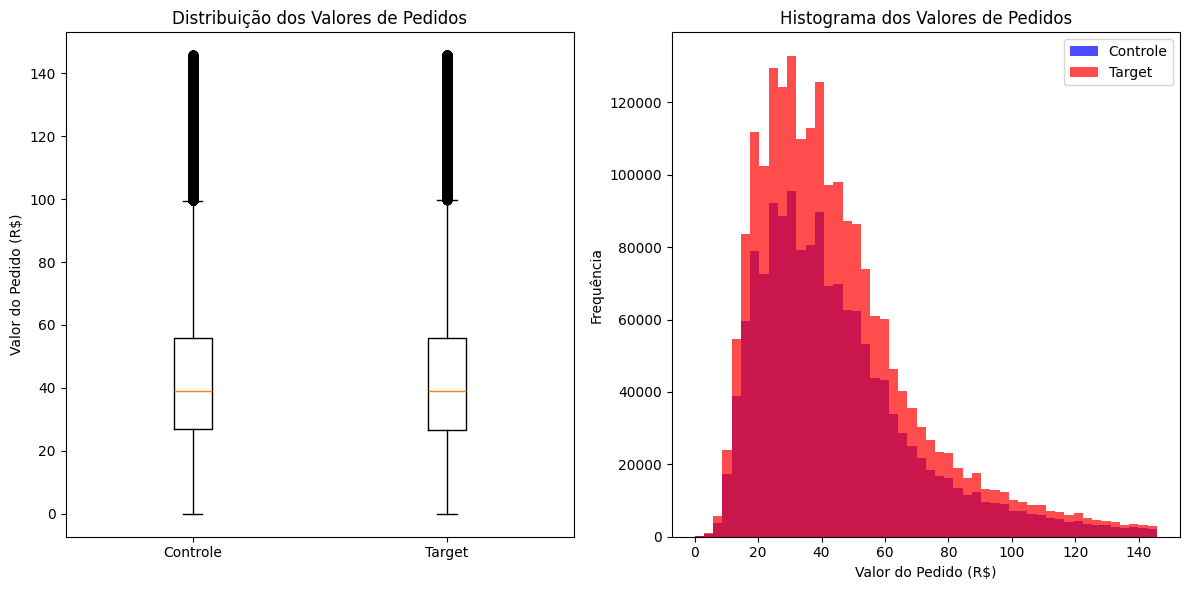



✅ Mini Dash criado com sucesso!


In [15]:
def create_final_dashboard(df_main, statistical_results, roi_results):
    """
    Cria dashboard final com todas as visualizações
    """
    print("🎨 CRIANDO DASHBOARD FINAL...")

    # Gráfico de comparação de métricas
    metrics_comparison = df_main.groupBy("is_target") \
        .agg(
            avg("order_total_amount").alias("avg_ticket"),
            count("*").alias("total_orders"),
            countDistinct("customer_id").alias("unique_users")
        ).toPandas()

    fig_comparison = go.Figure()

    # Ticket médio
    fig_comparison.add_trace(go.Bar(
        name='Ticket Médio (R$)',
        x=['Controle', 'Target'],
        y=[metrics_comparison[metrics_comparison['is_target']=='control']['avg_ticket'].iloc[0],
           metrics_comparison[metrics_comparison['is_target']=='target']['avg_ticket'].iloc[0]],
        marker_color=['blue', 'red']
    ))

    fig_comparison.update_layout(
        title="🎯 Comparação de Ticket Médio: Controle vs Target",
        yaxis_title="Valor (R$)",
        height=400
    )

    fig_comparison.write_html("metrics_comparison.html")
    fig_comparison.show()

    # Box plot para distribuição dos valores
    plt.figure(figsize=(12, 6))

    control_values = df_main.filter(col("is_target") == "control") \
                           .select("order_total_amount").toPandas()
    treatment_values = df_main.filter(col("is_target") == "target") \
                             .select("order_total_amount").toPandas()

    plt.subplot(1, 2, 1)
    plt.boxplot([control_values['order_total_amount'], treatment_values['order_total_amount']],
                labels=['Controle', 'Target'])
    plt.title('Distribuição dos Valores de Pedidos')
    plt.ylabel('Valor do Pedido (R$)')

    plt.subplot(1, 2, 2)
    plt.hist(control_values['order_total_amount'], alpha=0.7, label='Controle', bins=50, color='blue')
    plt.hist(treatment_values['order_total_amount'], alpha=0.7, label='Target', bins=50, color='red')
    plt.legend()
    plt.title('Histograma dos Valores de Pedidos')
    plt.xlabel('Valor do Pedido (R$)')
    plt.ylabel('Frequência')

    plt.tight_layout()
    plt.savefig('distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n")
    print("✅ Mini Dash criado com sucesso!")


# Criar dashboard final
create_final_dashboard(df_main, statistical_results, roi_results)

# 5️⃣ Relatório Executivo, pós análise inicial

In [16]:
def generate_executive_report(statistical_results, roi_results):
    """
    Gera relatório executivo com insights e recomendações
    """
    print("📝 RELATÓRIO EXECUTIVO\n")
    print("="*60)
    print("🎯 ANÁLISE DE TESTE A/B - CAMPANHA DE CUPONS IFOOD")
    print("="*60)

    print("\n📊 PRINCIPAIS RESULTADOS:")
    print(f"• Lift de Ticket Médio: {statistical_results['lift']:.2f}%")
    print(f"• Incremento de Receita por Usuário: R$ {roi_results['revenue_lift']:.2f}")
    print(f"• Significância Estatística: {'SIM' if statistical_results['t_test']['pvalue'] < 0.05 else 'NÃO'}")

    print("\n💡 INSIGHTS PRINCIPAIS:")
    if statistical_results['lift'] > 0:
        print("✅ A campanha de cupons teve IMPACTO POSITIVO no ticket médio")
        print(f"✅ Usuários do grupo Target gastaram em média {statistical_results['lift']:.2f}% mais")
    else:
        print("❌ A campanha de cupons teve IMPACTO NEGATIVO no ticket médio")

    if statistical_results['t_test']['pvalue'] < 0.05:
        print("✅ A diferença é ESTATISTICAMENTE SIGNIFICATIVA")
    else:
        print("⚠️ A diferença NÃO é estatisticamente significativa")

    print("\n💰 VIABILIDADE FINANCEIRA:")
    if roi_results['revenue_lift'] > 15:  # Assumindo cupom de R$ 15
        print("✅ A campanha é FINANCEIRAMENTE VIÁVEL para cupons até R$ 15")
    else:
        print("❌ A campanha pode NÃO ser viável dependendo do custo do cupom")

    print("\n🎯 RECOMENDAÇÕES E SUGESTÕES DE SEGMENTACAO:")
    print("1. 📈 Escalar a campanha de cupons se ROI > 20%")
    print("3. ⏰ Analisar impacto temporal (fins de semana vs dias úteis)")
    print("4. 💳 Testar diferentes valores de cupons")
    print("5. 🎪 Implementar campanhas sazonais estratégicas")

    print("\n📈 PRÓXIMOS PASSOS:")
    print("• Implementar análise de coorte para medir retenção de longo prazo")
    print("• Segmentar análise por cidade, categoria de restaurante e perfil de usuário")
    print("• Desenvolver modelo preditivo para otimizar targeting de cupons")
    print("• Estabelecer programa de monitoramento contínuo de métricas")

# Gerar relatório
generate_executive_report(statistical_results, roi_results)

📝 RELATÓRIO EXECUTIVO

🎯 ANÁLISE DE TESTE A/B - CAMPANHA DE CUPONS IFOOD

📊 PRINCIPAIS RESULTADOS:
• Lift de Ticket Médio: -0.02%
• Incremento de Receita por Usuário: R$ 24.36
• Significância Estatística: NÃO

💡 INSIGHTS PRINCIPAIS:
❌ A campanha de cupons teve IMPACTO NEGATIVO no ticket médio
⚠️ A diferença NÃO é estatisticamente significativa

💰 VIABILIDADE FINANCEIRA:
✅ A campanha é FINANCEIRAMENTE VIÁVEL para cupons até R$ 15

🎯 RECOMENDAÇÕES E SUGESTÕES DE SEGMENTACAO:
1. 📈 Escalar a campanha de cupons se ROI > 20%
3. ⏰ Analisar impacto temporal (fins de semana vs dias úteis)
4. 💳 Testar diferentes valores de cupons
5. 🎪 Implementar campanhas sazonais estratégicas

📈 PRÓXIMOS PASSOS:
• Implementar análise de coorte para medir retenção de longo prazo
• Segmentar análise por cidade, categoria de restaurante e perfil de usuário
• Desenvolver modelo preditivo para otimizar targeting de cupons
• Estabelecer programa de monitoramento contínuo de métricas


# 6️⃣ Outras métricas e visualizações

## 6.1 Segmentação de recorrência

In [17]:
from pyspark.sql import Window
from pyspark.sql.functions import col, min as pyspark_min, when

window_cust = Window.partitionBy("customer_id")

df_main = df_main.withColumn( # PRimeira compra de cada usuário
    "first_order_date",
    pyspark_min("order_date").over(window_cust)
)

df_main = df_main.withColumn( #Segmenta o cliente, comprou pela primeira vez ou ja comprou antes?
    "tipo_cliente",
    when(col("order_date") == col("first_order_date"), "novo")
    .otherwise("recorrente")
)


df_main.select(
    "customer_id", "order_id", "order_date", "tipo_cliente"
).show(10)


+--------------------+--------------------+----------+------------+
|         customer_id|            order_id|order_date|tipo_cliente|
+--------------------+--------------------+----------+------------+
|0021e78f5b3ee22e5...|acce457ce5c3c4989...|2019-01-22|  recorrente|
|0021e78f5b3ee22e5...|15b0853436d430c9d...|2019-01-07|  recorrente|
|0021e78f5b3ee22e5...|acce457ce5c3c4989...|2018-12-23|  recorrente|
|0021e78f5b3ee22e5...|15b0853436d430c9d...|2018-12-08|        novo|
|0048cfb9a19c77b46...|4b79c51c1b3294496...|2019-01-20|  recorrente|
|0048cfb9a19c77b46...|4b79c51c1b3294496...|2018-12-21|        novo|
|0098340481a328f6f...|af61fff6842b77195...|2019-01-12|  recorrente|
|0098340481a328f6f...|8dfa114a75cfddff2...|2019-01-29|  recorrente|
|0098340481a328f6f...|af61fff6842b77195...|2018-12-13|        novo|
|0098340481a328f6f...|8dfa114a75cfddff2...|2018-12-30|  recorrente|
+--------------------+--------------------+----------+------------+
only showing top 10 rows



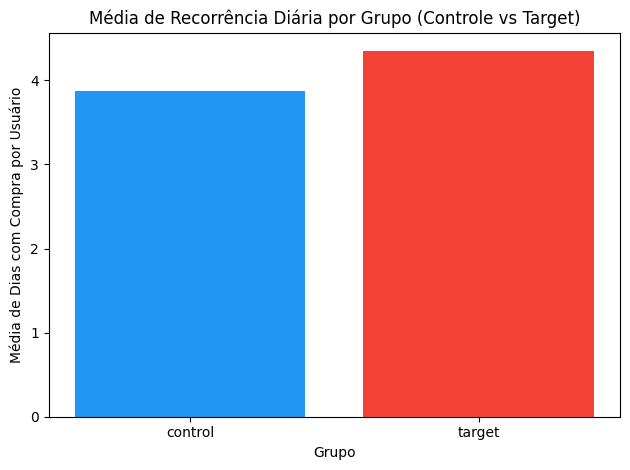

In [18]:
from pyspark.sql import functions as F
from pyspark.sql import Window

df_main = df_main.withColumn("order_date", F.to_date("order_date")) # Trata a tipagem da coluna

user_days = df_main.select( # Separa os dias (Dias distintos da compra)
    "customer_id", "is_target", "order_date"
).distinct()

# Conta o número de dias que cada cliente comprou em cada grupo
recorrencia = user_days.groupBy("customer_id", "is_target") \
    .agg(F.countDistinct("order_date").alias("dias_compra"))

# Média de dias com compra em cada grupo
recorrencia_grupo = recorrencia.groupBy("is_target") \
    .agg(F.avg("dias_compra").alias("media_recorrencia_diaria"))


recorrencia_pandas = recorrencia_grupo.toPandas() # Converter para pandas para plotar, só pra facilitar a vida mesmo...

import matplotlib.pyplot as plt

plt.bar(recorrencia_pandas['is_target'], recorrencia_pandas['media_recorrencia_diaria'], color=['#2196f3', '#f44336'])
plt.title('Média de Recorrência Diária por Grupo (Controle vs Target)')
plt.xlabel('Grupo')
plt.ylabel('Média de Dias com Compra por Usuário')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 6.1.1 Recorrência Diária p/ Grupo

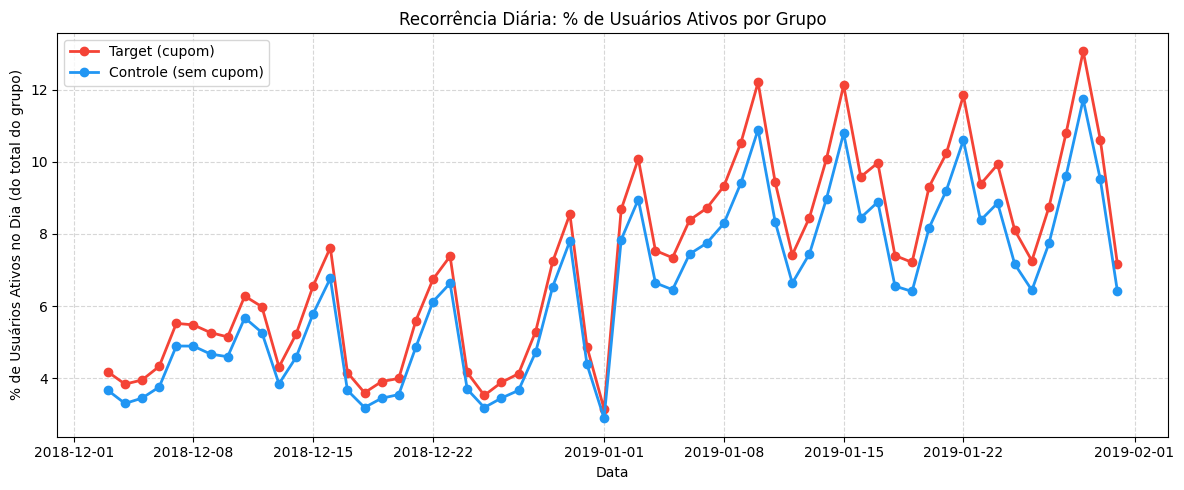

In [19]:
from pyspark.sql import functions as F

# Garante que order_date é date hehe
df_main = df_main.withColumn("order_date", F.to_date("order_date"))

# Usuários únicos por grupo
usuarios_por_grupo = df_main.groupBy("is_target") \
  .agg(F.countDistinct("customer_id").alias("total_users"))


# Número de usuários que compraram por grupo em cada dia
usuarios_dia = df_main.groupBy("order_date", "is_target") \
    .agg(F.countDistinct("customer_id").alias("usuarios_ativos_dia"))

# Faz o join para trazer o total de usuários de cada grupo
usuarios_dia = usuarios_dia.join(usuarios_por_grupo, on="is_target", how="left")

# % Recorrência diaria por grupo
usuarios_dia = usuarios_dia.withColumn(
    "perc_clientes_ativos",
    (F.col("usuarios_ativos_dia") / F.col("total_users")) * 100
)


usuarios_dia_pd = usuarios_dia.select(
    "order_date", "is_target", "perc_clientes_ativos"
).orderBy("order_date", "is_target").toPandas()


import matplotlib.pyplot as plt

# coluna por grupo
pivot = usuarios_dia_pd.pivot(index='order_date', columns='is_target', values='perc_clientes_ativos')

plt.figure(figsize=(12, 5))
plt.plot(pivot.index, pivot['target'], label='Target (cupom)', color='#f44336', linewidth=2, marker='o')
plt.plot(pivot.index, pivot['control'], label='Controle (sem cupom)', color='#2196f3', linewidth=2, marker='o')
plt.title('Recorrência Diária: % de Usuários Ativos por Grupo')
plt.xlabel('Data')
plt.ylabel('% de Usuários Ativos no Dia (do total do grupo)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 6.2 Segmentação por perfil de consumo

- **"Baixo Consumo"** – Poucos pedidos, baixo ticket
- **"Alto Consumo Esporádico"** – Poucos pedidos, ticket alto
- **"Alto Frequência"** – Muitos pedidos independentemente do ticket
- **"Fidelizado Premium"** – Muitos pedidos e ticket médio alto
- **"Recente"** – Primeira compra na janela de análise
- **"Churn**" – Sem compras nos últimos X dias/meses

In [20]:
from pyspark.sql.functions import col, when, countDistinct, avg, sum as pysum, min as pysmin, max as pysmax, lit
from pyspark.sql import Window


print("Baixo Consumo – Poucos pedidos, baixo ticket (ex: ticket médio < R$50, <=2 compras)")
print("Alto Consumo Esporádico – Poucos pedidos, ticket alto (ex: ticket médio >= R$80, <=2 compras)")
print("Alto Frequência – Muitos pedidos independentemente do ticket (ex: >=5 compras, qualquer ticket)")
print("Fidelizado Premium – Muitos pedidos e ticket médio alto (ex: >=5 compras, ticket médio >= R$80)")
print("Recente – Primeira compra na janela de análise")
print("Churn – Sem compras nos últimos X dias/meses\n")

#  resumo de pedidos
window_user = Window.partitionBy("customer_id")

perf_user = df_main.groupBy("customer_id").agg(
    countDistinct("order_id").alias("qtd_pedidos"),
    pysum("order_total_amount").alias("valor_total"),
    avg("order_total_amount").alias("ticket_medio"),
    pysmin("order_date").alias("primeira_compra"),
    pysmax("order_date").alias("ultima_compra")
)

# Verifica se é recente, a Frequência e o Ticket Médio
PERIODO_ANALISE_FIM = "2019-02-01" # A maior data da tabela é 2019-01-31
INTERVAL_RECENCIA_DIAS = 30  #comprou nos ultimos 30 dias?

perf_user = perf_user.withColumn(
    "recente", col("primeira_compra") >= lit(f"{PERIODO_ANALISE_FIM}").cast("date") - expr(f"INTERVAL {INTERVAL_RECENCIA_DIAS} DAYS")
).withColumn(
    "churn", col("ultima_compra") < lit(f"{PERIODO_ANALISE_FIM}").cast("date") - expr(f"INTERVAL {INTERVAL_RECENCIA_DIAS} DAYS")
)

# Classificação de perfis
perf_user = perf_user.withColumn(
    "perfil_consumo",
    when(col("qtd_pedidos") <= 2,
         when(col("ticket_medio") < 50, "Baixo Consumo")
         .when(col("ticket_medio") >= 80, "Alto Consumo Esporádico")
         .otherwise("Intermediário"))
    .when((col("qtd_pedidos") >= 5) & (col("ticket_medio") >= 80), "Fidelizado Premium")
    .when(col("qtd_pedidos") >= 5, "Alta Frequência")
    .when(col("recente") == True, "Recente")
    .when(col("churn") == True, "Churn")
    .otherwise("Moderado")
)

perf_user.groupBy("perfil_consumo").count().orderBy("count", ascending=False).show()


Baixo Consumo – Poucos pedidos, baixo ticket (ex: ticket médio < R$50, <=2 compras)
Alto Consumo Esporádico – Poucos pedidos, ticket alto (ex: ticket médio >= R$80, <=2 compras)
Alto Frequência – Muitos pedidos independentemente do ticket (ex: >=5 compras, qualquer ticket)
Fidelizado Premium – Muitos pedidos e ticket médio alto (ex: >=5 compras, ticket médio >= R$80)
Recente – Primeira compra na janela de análise
Churn – Sem compras nos últimos X dias/meses

+--------------------+------+
|      perfil_consumo| count|
+--------------------+------+
|       Baixo Consumo|354888|
|     Alta Frequência|133152|
|               Churn|132996|
|       Intermediário|124049|
|Alto Consumo Espo...| 46294|
|  Fidelizado Premium|  6746|
+--------------------+------+



## 6.3 Segmentação p/ Perfil de consumo, mas agora separado por grupo

+---------+--------------------+------+
|is_target|      perfil_consumo| count|
+---------+--------------------+------+
|   target|       Baixo Consumo|187868|
|   target|               Churn| 79639|
|   target|     Alta Frequência| 79627|
|   target|       Intermediário| 65974|
|   target|Alto Consumo Espo...| 24511|
|   target|  Fidelizado Premium|  4024|
|  control|       Baixo Consumo|167020|
|  control|       Intermediário| 58075|
|  control|     Alta Frequência| 53525|
|  control|               Churn| 53357|
|  control|Alto Consumo Espo...| 21783|
|  control|  Fidelizado Premium|  2722|
+---------+--------------------+------+



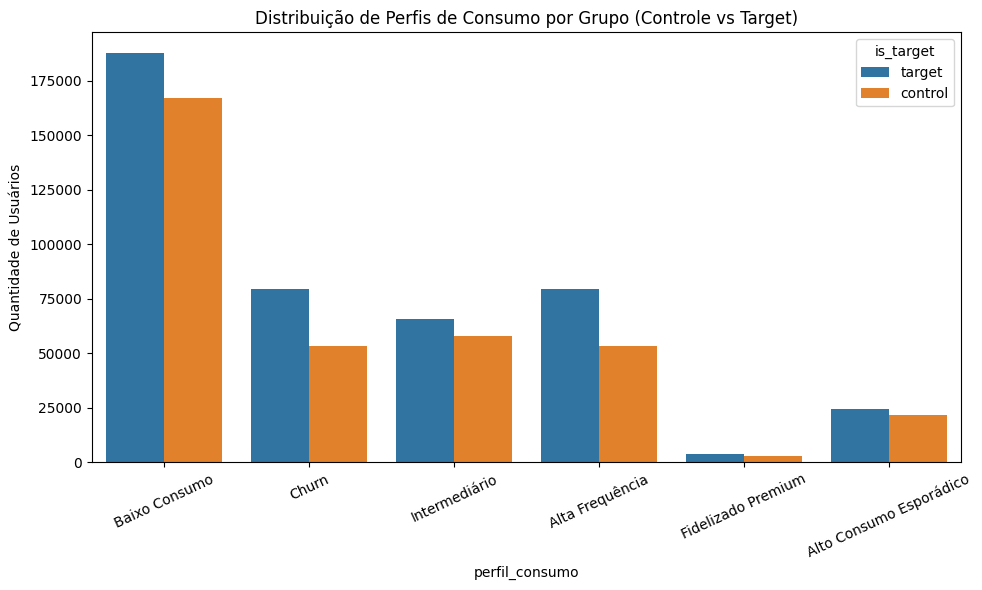

In [21]:
grupo_usuario = df_main.select("customer_id", "is_target").dropDuplicates(["customer_id"])
perf_user = perf_user.join(grupo_usuario, on="customer_id", how="left")

# Distribuição de perfis por grupo
perf_user.groupBy("is_target", "perfil_consumo").count().orderBy("is_target", "count", ascending=False).show()

#
perf_perfil_pandas = perf_user.groupBy("is_target", "perfil_consumo") \
    .count().toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(
    data=perf_perfil_pandas,
    x="perfil_consumo", y="count", hue="is_target"
)
plt.title("Distribuição de Perfis de Consumo por Grupo (Controle vs Target)")
plt.ylabel("Quantidade de Usuários")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()
